# Getting started with mPDFmodules

The mpdfmodules plugin aims to provide a flexible, object-oriented framework for computing the magnetic PDF from a magnetic structure and performing refinements against neutron scattering data. This notebook gives an overview of how the mPDF software is organized and provides introductory examples of computing mPDFs. Additional examples, including refinements of the mPDF against actual data, are included in the other python scripts here on the CMI Exchange.

## Class structure of the mpdfmodules plugin

The mpdfmodules plugin contains several functions and three classes to aid in the mPDF calculations--the mPDFcalculator class, the magStructure class, and the magSpecies class, which is optional but highly useful for many magnetic structures.

### magStructure class

The main job of a magStructure object is to contain a numpy array of atomic positions (magStructure.atoms) and a corresponding numpy array of magnetic moment vectors (magStructure.spins), which are the only two absolutely required ingredients for calculating the mPDF. Additional optional information such as the Lande g-factor or magnetic form factor can be stored in a magStructure object if it is needed (as it often is for performing mPDF refinements). A diffpy.Structure object corresponding to the atomic structure of the material can also be stored for convenience when generating the atomic positions and spin vectors. Multiple types of magnetic species (e.g. spins on different ionic sites that may have different moment sizes) can be stored inside a single magStructure object.

### magSpecies class

The magSpecies class is intended to provide an easy way to generate the atomic positions and spin vectors of a particular type of magnetic species in a structure. It takes a diffpy.Structure object and packages additional information pertaining to the magnetic structure, such as the magnetic propagation vector(s), magnetic basis vector(s), spin/orbital quantum numbers, and magnetic form factor. Alternatively, the user can define a unit cell populated with positions and spin orientations of the magnetic atoms, and this will be used rather than a diffpy.Structure object. The structural information is used in class methods that automatically generate the atomic positions and corresponding spin vectors, which can then be stored in a magStructure object. There are no limits on the number of propagation and basis vectors, allowing for arbitrarily complex magnetic structures. magSpecies objects can be loaded directly into a magStructure object or created from inside the magStructure object. Although a magSpecies object is not required to calculate the mPDF, it will usually provide the easiest way to populate the atom and spin arrays that are required for the mPDF. The reason for having separate magStructure and magSpecies classes is that a single magnetic structure may contain multiple magnetic species.

### mPDFcalculator class

The mPDFcalculator class handles the details of the calculation and contains information that is not directly related to the magnetic structure, such as the real-space calculation range, any damping or broadening profile to be applied to the mPDF, scale factors, and experimental parameters like q<sub>min</sub> and q<sub>max</sub>. It requires a magStructure object as input, from which it extracts the atomic positions and spin vectors to be used in calculating the mPDF. The mPDFcalculator class has options for calculating both the properly normalized and the unnormalized mPDF (the unnormalized mPDF is frequently what we obtain experimentally).

# Examples of calculating the mPDF

We will now use the mpdfmodules plugin to provide a couple of examples of calculating the mPDF. This will give you a basic idea of how the plugin works.

In [1]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from diffpy.magpdf import *

### Set all plots to be inline
%matplotlib notebook

### Simplest case: a structure consisting of two spins

<IPython.core.display.Javascript object>


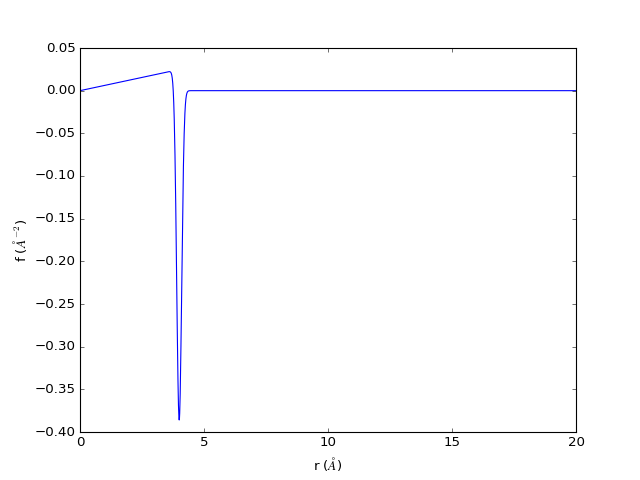

In [2]:
magstruc=magStructure()

### Create two atoms in the structure
magstruc.atoms=np.array([[0,0,0],[4,0,0]])

### Create two spin vectors corresponding to the atoms. Let's make them antiferromagnetic.
S=np.array([0,0,1])
magstruc.spins=np.array([S,-S])

### Create the mPDFcalculator object and load magstruc into it
mc=mPDFcalculator(magstruc)

### Calculate the mPDF!
r,fr=mc.calc()

### Plot
ax=plt.figure().add_subplot(111)
ax.plot(r,fr)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('f ($\AA^{-2}$)')

plt.show()

<IPython.core.display.Javascript object>


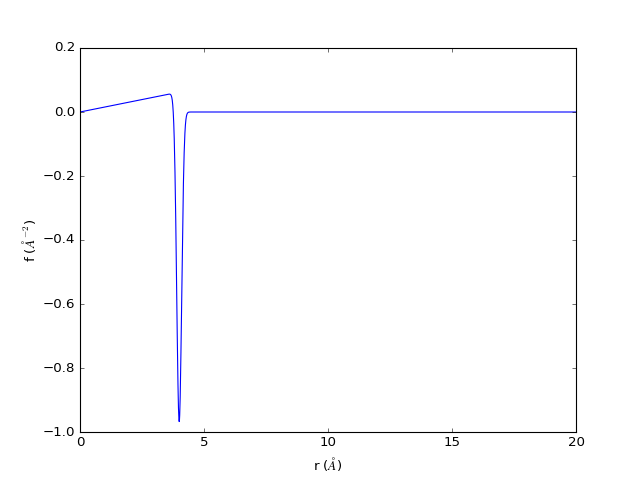

In [3]:
### Or if you just want to quickly plot the mPDF, you can call the plot method on the mPDFcalculator:
mc.plot()

Note that the negative peak at 4 Angstroms is due to the antiferromagnetic orientation of the spins. The sloping baseline at low-r is real and is a unique feature of the mPDF that is not found in the atomic PDF.

If the spins were oriented ferromagnetically, the mPDF peak would be positive. Let's take a look:

<IPython.core.display.Javascript object>


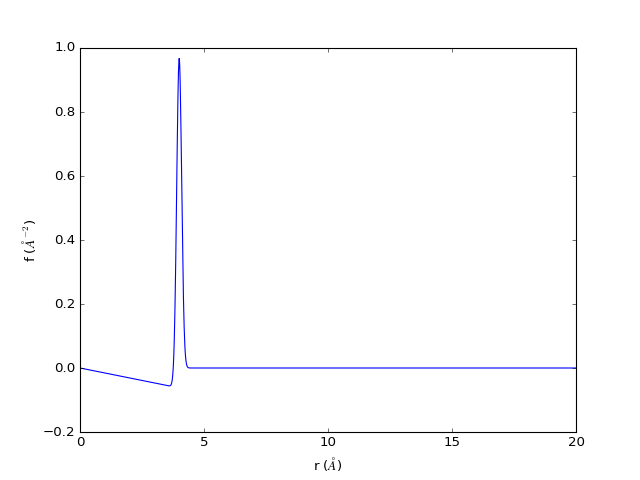

In [4]:
### Make the spins ferromagnetically aligned
magstruc.spins=np.array([S,S])

### Plot the result
mc.plot()

### Calculating the mPDF from a real material: antiferromagnetic MnO

This example will show how to use the magSpecies class and additional features in the magStructure class to quickly generate the atomic positions and spin vectors from a diffpy.Structure object. It will also show how to calculate the unnormalized mPDF, which is useful for comparison to and refinement against neutron total scattering data.

In [5]:
### First we have to import the loadStructure function from diffpy.Structure
from diffpy.Structure import loadStructure

### Now let's create a diffpy.Structure object from a CIF file for MnO. This has all the atomic information,
### but none of the magnetic information.
mno=loadStructure('MnO_cubic.cif')

### As a refresher, let's take a look at the mno structure object.
mno

[Mn2+ 0.000000 0.000000 0.000000 1.0000,
 Mn2+ 0.000000 0.500000 0.500000 1.0000,
 Mn2+ 0.500000 0.000000 0.500000 1.0000,
 Mn2+ 0.500000 0.500000 0.000000 1.0000,
 O2-  0.500000 0.500000 0.500000 1.0000,
 O2-  0.500000 0.000000 0.000000 1.0000,
 O2-  0.000000 0.500000 0.000000 1.0000,
 O2-  0.000000 0.000000 0.500000 1.0000]

In [6]:
### We will now create a magSpecies object to extend the mno structure object.
mnoMag=magSpecies()

### Load the mno structure and give the magnetic species a label
mnoMag.struc=mno
mnoMag.label='Mn2+'

### Now we need to tell it which atoms in MnO are magnetic. From the printed list in the previous cell,
### the magnetic Mn ions are the first four positions in the structure, so we provide the corresponding indices.
mnoMag.magIdxs=[0,1,2,3]

### Now we provide the magnetic propagation vectors and basis vectors, which are known from previous neutron
### diffraction studies of MnO.
k=np.array([0.5,0.5,0.5])
s=np.array([1,-1,0]) # we won't worry about the magnitude of the basis vector for now
mnoMag.kvecs=np.array([k])
mnoMag.basisvecs=np.array([s])

### Now we provide information about the magnetic form factor. We tell the magSpecies object the type of magnetic
### ion, and it looks up magnetic form factor in a table.
mnoMag.ffparamkey='Mn2'

In [7]:
### Now we can create a magStructure object and load mnoMag into it.
mnoMagStruc=magStructure()
mnoMagStruc.loadSpecies(mnoMag)

### Now we will generate the atomic positions and spins. It is important to do the atoms first, since the
### spins are generated by applying the propagation and basis vectors to the atomic positions.
mnoMagStruc.makeAtoms()
mnoMagStruc.makeSpins()

### And we make the magnetic form factor:
mnoMagStruc.makeFF()

Running checks for Mn2+ magSpecies object...

All magSpecies() checks passed. No obvious problems found.

Running checks for  magStructure object...

All magStructure checks passed. No obvious problems found.


/home/ben/anaconda/envs/magpdfdev/lib/python2.7/site-packages/diffpy.Structure-1.3.2-py2.7.egg/diffpy/Structure/lattice.py:125: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if [a, b, c, alpha, beta, gamma, base] == 7*[None]:


<IPython.core.display.Javascript object>


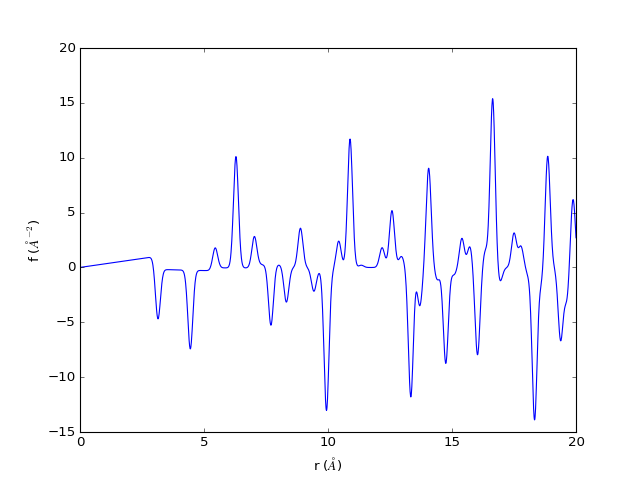

In [8]:
### Now we can make the mPDFcalculator object and feed it the magStructure.
mc=mPDFcalculator()
mc.magstruc=mnoMagStruc

### Let's see what the mPDF looks like:
mc.plot()

<IPython.core.display.Javascript object>


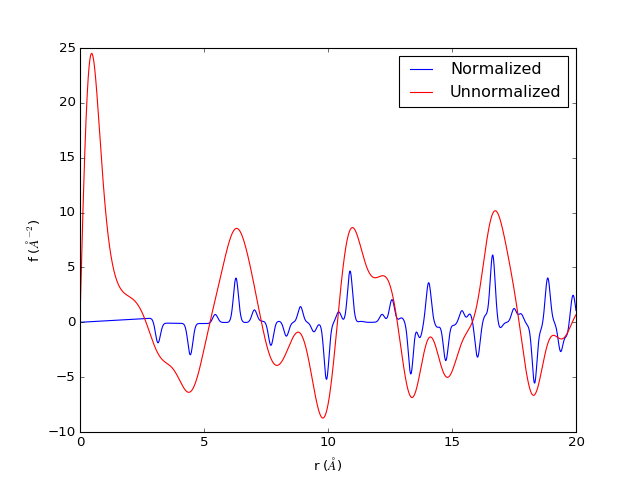

In [9]:
### Now let's plot the unnormalized mPDF, which is the proper mPDF broadened out by the Fourier transform
### of the magnetic form factor.

r,fr,dr=mc.calc(both=True)

### Plot
ax=plt.figure().add_subplot(111)
ax.plot(r,fr,'b-',label='Normalized')
ax.plot(r,dr,'r-',label='Unnormalized')
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('f ($\AA^{-2}$)')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


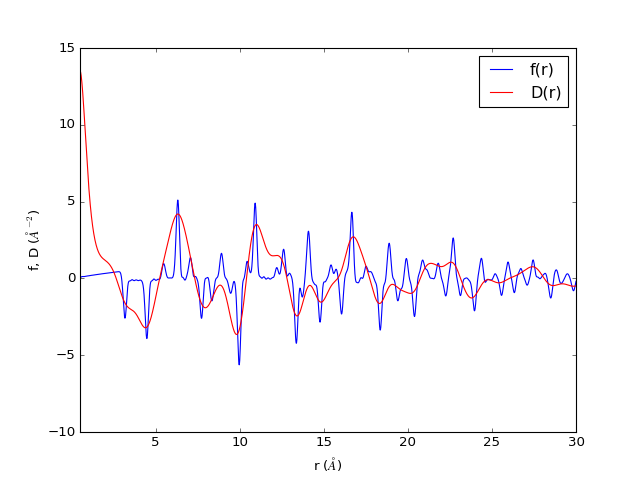

In [10]:
### We can also change many other parameters of the mPDF calculation.
### For example, let's change the calculation range, let's set an experimental qmin and qmax to include the
### termination effects, and let's apply a damping profile.

# change the calculation range:
mc.rmin,mc.rmax=0.5,30.0

# provide qumin and qmax
mc.qmin,mc.qmax=0.1,25.0

# apply a damping profile
mc.dampRate=0.1 ## in inverse Angstroms

mc.plot(both=True)

### This is a very basic overview of how the mpdfmodules plugin works. Try out the other example scripts for more complicated magnetic structures and for examples of refining the mPDF against actual data. Then go on and use it for your own data!